In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from numba import jit, float64, int64

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../_00_data/Sepulveda2020_perceptual_prep.csv', index_col=0)

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_train = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

obs_test = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_test = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

print(X_train.shape, X_test.shape)

(7555, 5) (7555, 5)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2, 1e-14)), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 10, 8]
input_shape = 5
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 out_layer (Out_layer)       (None, 2)                 114       
                                                                 
Total params: 482 (1.88 KB)
Trainable params: 482 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3000)

Epoch 1/3000
1/1 [==============================] - 1s 591ms/step - loss: 70994.1562
Epoch 2/3000
1/1 [==============================] - 0s 3ms/step - loss: 70417.1406
Epoch 3/3000
1/1 [==============================] - 0s 3ms/step - loss: 70041.2031
Epoch 4/3000
1/1 [==============================] - 0s 10ms/step - loss: 69754.1250
Epoch 5/3000
1/1 [==============================] - 0s 5ms/step - loss: 69510.2812
Epoch 6/3000
1/1 [==============================] - 0s 4ms/step - loss: 69290.3438
Epoch 7/3000
1/1 [==============================] - 0s 4ms/step - loss: 69085.8828
Epoch 8/3000
1/1 [==============================] - 0s 4ms/step - loss: 68892.4844
Epoch 9/3000
1/1 [==============================] - 0s 5ms/step - loss: 68707.5312
Epoch 10/3000
1/1 [==============================] - 0s 6ms/step - loss: 68529.2188
Epoch 11/3000
1/1 [==============================] - 0s 4ms/step - loss: 68356.3281
Epoch 12/3000
1/1 [==============================] - 0s 4ms/step - loss: 68187.929

1/1 [==============================] - 0s 5ms/step - loss: 58940.8047
Epoch 99/3000
1/1 [==============================] - 0s 5ms/step - loss: 58874.3555
Epoch 100/3000
1/1 [==============================] - 0s 4ms/step - loss: 58808.5547
Epoch 101/3000
1/1 [==============================] - 0s 4ms/step - loss: 58743.3867
Epoch 102/3000
1/1 [==============================] - 0s 4ms/step - loss: 58678.8438
Epoch 103/3000
1/1 [==============================] - 0s 4ms/step - loss: 58614.9219
Epoch 104/3000
1/1 [==============================] - 0s 4ms/step - loss: 58551.6094
Epoch 105/3000
1/1 [==============================] - 0s 4ms/step - loss: 58488.8945
Epoch 106/3000
1/1 [==============================] - 0s 4ms/step - loss: 58426.7734
Epoch 107/3000
1/1 [==============================] - 0s 4ms/step - loss: 58365.2305
Epoch 108/3000
1/1 [==============================] - 0s 4ms/step - loss: 58304.2656
Epoch 109/3000
1/1 [==============================] - 0s 4ms/step - loss: 58243.8

1/1 [==============================] - 0s 3ms/step - loss: 54521.9219
Epoch 195/3000
1/1 [==============================] - 0s 4ms/step - loss: 54489.2383
Epoch 196/3000
1/1 [==============================] - 0s 4ms/step - loss: 54456.7305
Epoch 197/3000
1/1 [==============================] - 0s 4ms/step - loss: 54424.3867
Epoch 198/3000
1/1 [==============================] - 0s 3ms/step - loss: 54392.2031
Epoch 199/3000
1/1 [==============================] - 0s 4ms/step - loss: 54360.1836
Epoch 200/3000
1/1 [==============================] - 0s 3ms/step - loss: 54328.3281
Epoch 201/3000
1/1 [==============================] - 0s 4ms/step - loss: 54296.6250
Epoch 202/3000
1/1 [==============================] - 0s 4ms/step - loss: 54265.0859
Epoch 203/3000
1/1 [==============================] - 0s 4ms/step - loss: 54233.6992
Epoch 204/3000
1/1 [==============================] - 0s 4ms/step - loss: 54202.4531
Epoch 205/3000
1/1 [==============================] - 0s 4ms/step - loss: 54171.

1/1 [==============================] - 0s 4ms/step - loss: 51931.4492
Epoch 291/3000
1/1 [==============================] - 0s 4ms/step - loss: 51908.5508
Epoch 292/3000
1/1 [==============================] - 0s 4ms/step - loss: 51885.7109
Epoch 293/3000
1/1 [==============================] - 0s 4ms/step - loss: 51862.9297
Epoch 294/3000
1/1 [==============================] - 0s 4ms/step - loss: 51840.2031
Epoch 295/3000
1/1 [==============================] - 0s 5ms/step - loss: 51817.5391
Epoch 296/3000
1/1 [==============================] - 0s 5ms/step - loss: 51794.9297
Epoch 297/3000
1/1 [==============================] - 0s 4ms/step - loss: 51772.3789
Epoch 298/3000
1/1 [==============================] - 0s 4ms/step - loss: 51749.8789
Epoch 299/3000
1/1 [==============================] - 0s 4ms/step - loss: 51727.4375
Epoch 300/3000
1/1 [==============================] - 0s 4ms/step - loss: 51705.0469
Epoch 301/3000
1/1 [==============================] - 0s 4ms/step - loss: 51682.

1/1 [==============================] - 0s 4ms/step - loss: 49942.0195
Epoch 387/3000
1/1 [==============================] - 0s 4ms/step - loss: 49923.0430
Epoch 388/3000
1/1 [==============================] - 0s 4ms/step - loss: 49904.0977
Epoch 389/3000
1/1 [==============================] - 0s 4ms/step - loss: 49885.1719
Epoch 390/3000
1/1 [==============================] - 0s 4ms/step - loss: 49866.2891
Epoch 391/3000
1/1 [==============================] - 0s 4ms/step - loss: 49847.4297
Epoch 392/3000
1/1 [==============================] - 0s 4ms/step - loss: 49828.6016
Epoch 393/3000
1/1 [==============================] - 0s 4ms/step - loss: 49809.7969
Epoch 394/3000
1/1 [==============================] - 0s 4ms/step - loss: 49791.0234
Epoch 395/3000
1/1 [==============================] - 0s 4ms/step - loss: 49772.2734
Epoch 396/3000
1/1 [==============================] - 0s 4ms/step - loss: 49753.5547
Epoch 397/3000
1/1 [==============================] - 0s 4ms/step - loss: 49734.

1/1 [==============================] - 0s 4ms/step - loss: 48235.3086
Epoch 483/3000
1/1 [==============================] - 0s 4ms/step - loss: 48218.6172
Epoch 484/3000
1/1 [==============================] - 0s 4ms/step - loss: 48201.9453
Epoch 485/3000
1/1 [==============================] - 0s 4ms/step - loss: 48185.2969
Epoch 486/3000
1/1 [==============================] - 0s 5ms/step - loss: 48168.6680
Epoch 487/3000
1/1 [==============================] - 0s 4ms/step - loss: 48152.0508
Epoch 488/3000
1/1 [==============================] - 0s 4ms/step - loss: 48135.4570
Epoch 489/3000
1/1 [==============================] - 0s 5ms/step - loss: 48118.8906
Epoch 490/3000
1/1 [==============================] - 0s 4ms/step - loss: 48102.3438
Epoch 491/3000
1/1 [==============================] - 0s 4ms/step - loss: 48085.8125
Epoch 492/3000
1/1 [==============================] - 0s 5ms/step - loss: 48069.2969
Epoch 493/3000
1/1 [==============================] - 0s 4ms/step - loss: 48052.

1/1 [==============================] - 0s 5ms/step - loss: 46721.1250
Epoch 579/3000
1/1 [==============================] - 0s 4ms/step - loss: 46706.2578
Epoch 580/3000
1/1 [==============================] - 0s 4ms/step - loss: 46691.4062
Epoch 581/3000
1/1 [==============================] - 0s 4ms/step - loss: 46676.5664
Epoch 582/3000
1/1 [==============================] - 0s 4ms/step - loss: 46661.7578
Epoch 583/3000
1/1 [==============================] - 0s 4ms/step - loss: 46646.9531
Epoch 584/3000
1/1 [==============================] - 0s 4ms/step - loss: 46632.1680
Epoch 585/3000
1/1 [==============================] - 0s 4ms/step - loss: 46617.4062
Epoch 586/3000
1/1 [==============================] - 0s 4ms/step - loss: 46602.6562
Epoch 587/3000
1/1 [==============================] - 0s 4ms/step - loss: 46587.9297
Epoch 588/3000
1/1 [==============================] - 0s 4ms/step - loss: 46573.2109
Epoch 589/3000
1/1 [==============================] - 0s 4ms/step - loss: 46558.

1/1 [==============================] - 0s 4ms/step - loss: 45366.7188
Epoch 675/3000
1/1 [==============================] - 0s 4ms/step - loss: 45353.3516
Epoch 676/3000
1/1 [==============================] - 0s 4ms/step - loss: 45340.0000
Epoch 677/3000
1/1 [==============================] - 0s 4ms/step - loss: 45326.6406
Epoch 678/3000
1/1 [==============================] - 0s 4ms/step - loss: 45313.3164
Epoch 679/3000
1/1 [==============================] - 0s 4ms/step - loss: 45299.9961
Epoch 680/3000
1/1 [==============================] - 0s 4ms/step - loss: 45286.6875
Epoch 681/3000
1/1 [==============================] - 0s 4ms/step - loss: 45273.3906
Epoch 682/3000
1/1 [==============================] - 0s 76ms/step - loss: 45260.1211
Epoch 683/3000
1/1 [==============================] - 0s 27ms/step - loss: 45246.8516
Epoch 684/3000
1/1 [==============================] - 0s 10ms/step - loss: 45233.6016
Epoch 685/3000
1/1 [==============================] - 0s 8ms/step - loss: 452

1/1 [==============================] - 0s 4ms/step - loss: 44044.2891
Epoch 771/3000
1/1 [==============================] - 0s 4ms/step - loss: 44030.8086
Epoch 772/3000
1/1 [==============================] - 0s 4ms/step - loss: 44016.9453
Epoch 773/3000
1/1 [==============================] - 0s 4ms/step - loss: 44003.5234
Epoch 774/3000
1/1 [==============================] - 0s 3ms/step - loss: 43989.5898
Epoch 775/3000
1/1 [==============================] - 0s 4ms/step - loss: 43976.1172
Epoch 776/3000
1/1 [==============================] - 0s 4ms/step - loss: 43962.0312
Epoch 777/3000
1/1 [==============================] - 0s 4ms/step - loss: 43948.3906
Epoch 778/3000
1/1 [==============================] - 0s 4ms/step - loss: 43934.1445
Epoch 779/3000
1/1 [==============================] - 0s 4ms/step - loss: 43920.2266
Epoch 780/3000
1/1 [==============================] - 0s 4ms/step - loss: 43905.7891
Epoch 781/3000
1/1 [==============================] - 0s 4ms/step - loss: 43891.

1/1 [==============================] - 0s 4ms/step - loss: 42716.2969
Epoch 867/3000
1/1 [==============================] - 0s 4ms/step - loss: 42704.1445
Epoch 868/3000
1/1 [==============================] - 0s 4ms/step - loss: 42690.2969
Epoch 869/3000
1/1 [==============================] - 0s 4ms/step - loss: 42678.1758
Epoch 870/3000
1/1 [==============================] - 0s 4ms/step - loss: 42664.3164
Epoch 871/3000
1/1 [==============================] - 0s 4ms/step - loss: 42652.2148
Epoch 872/3000
1/1 [==============================] - 0s 4ms/step - loss: 42638.2695
Epoch 873/3000
1/1 [==============================] - 0s 4ms/step - loss: 42626.1289
Epoch 874/3000
1/1 [==============================] - 0s 4ms/step - loss: 42611.9453
Epoch 875/3000
1/1 [==============================] - 0s 4ms/step - loss: 42599.6016
Epoch 876/3000
1/1 [==============================] - 0s 4ms/step - loss: 42584.8672
Epoch 877/3000
1/1 [==============================] - 0s 4ms/step - loss: 42572.

1/1 [==============================] - 0s 4ms/step - loss: 41347.2109
Epoch 963/3000
1/1 [==============================] - 0s 3ms/step - loss: 41339.1875
Epoch 964/3000
1/1 [==============================] - 0s 3ms/step - loss: 41323.6992
Epoch 965/3000
1/1 [==============================] - 0s 4ms/step - loss: 41315.8984
Epoch 966/3000
1/1 [==============================] - 0s 4ms/step - loss: 41300.3906
Epoch 967/3000
1/1 [==============================] - 0s 4ms/step - loss: 41292.7383
Epoch 968/3000
1/1 [==============================] - 0s 4ms/step - loss: 41277.0312
Epoch 969/3000
1/1 [==============================] - 0s 5ms/step - loss: 41269.3516
Epoch 970/3000
1/1 [==============================] - 0s 5ms/step - loss: 41253.3906
Epoch 971/3000
1/1 [==============================] - 0s 6ms/step - loss: 41245.5586
Epoch 972/3000
1/1 [==============================] - 0s 4ms/step - loss: 41229.3281
Epoch 973/3000
1/1 [==============================] - 0s 5ms/step - loss: 41221.

1/1 [==============================] - 0s 4ms/step - loss: 40282.8750
Epoch 1058/3000
1/1 [==============================] - 0s 4ms/step - loss: 40264.3750
Epoch 1059/3000
1/1 [==============================] - 0s 4ms/step - loss: 40262.2734
Epoch 1060/3000
1/1 [==============================] - 0s 4ms/step - loss: 40243.7617
Epoch 1061/3000
1/1 [==============================] - 0s 4ms/step - loss: 40241.7695
Epoch 1062/3000
1/1 [==============================] - 0s 4ms/step - loss: 40223.2422
Epoch 1063/3000
1/1 [==============================] - 0s 4ms/step - loss: 40221.3594
Epoch 1064/3000
1/1 [==============================] - 0s 4ms/step - loss: 40202.8203
Epoch 1065/3000
1/1 [==============================] - 0s 4ms/step - loss: 40201.0273
Epoch 1066/3000
1/1 [==============================] - 0s 4ms/step - loss: 40182.4688
Epoch 1067/3000
1/1 [==============================] - 0s 7ms/step - loss: 40180.8047
Epoch 1068/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 39378.3984
Epoch 1153/3000
1/1 [==============================] - 0s 4ms/step - loss: 39382.0039
Epoch 1154/3000
1/1 [==============================] - 0s 4ms/step - loss: 39360.7812
Epoch 1155/3000
1/1 [==============================] - 0s 4ms/step - loss: 39364.5117
Epoch 1156/3000
1/1 [==============================] - 0s 4ms/step - loss: 39343.1836
Epoch 1157/3000
1/1 [==============================] - 0s 4ms/step - loss: 39347.0430
Epoch 1158/3000
1/1 [==============================] - 0s 5ms/step - loss: 39325.6172
Epoch 1159/3000
1/1 [==============================] - 0s 4ms/step - loss: 39329.6094
Epoch 1160/3000
1/1 [==============================] - 0s 5ms/step - loss: 39308.0781
Epoch 1161/3000
1/1 [==============================] - 0s 6ms/step - loss: 39312.2031
Epoch 1162/3000
1/1 [==============================] - 0s 7ms/step - loss: 39290.5469
Epoch 1163/3000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 38557.5508
Epoch 1248/3000
1/1 [==============================] - 0s 5ms/step - loss: 38502.3203
Epoch 1249/3000
1/1 [==============================] - 0s 6ms/step - loss: 38540.0625
Epoch 1250/3000
1/1 [==============================] - 0s 5ms/step - loss: 38484.2227
Epoch 1251/3000
1/1 [==============================] - 0s 5ms/step - loss: 38522.3906
Epoch 1252/3000
1/1 [==============================] - 0s 5ms/step - loss: 38466.1914
Epoch 1253/3000
1/1 [==============================] - 0s 4ms/step - loss: 38504.9375
Epoch 1254/3000
1/1 [==============================] - 0s 4ms/step - loss: 38448.1641
Epoch 1255/3000
1/1 [==============================] - 0s 6ms/step - loss: 38487.2969
Epoch 1256/3000
1/1 [==============================] - 0s 5ms/step - loss: 38430.1992
Epoch 1257/3000
1/1 [==============================] - 0s 5ms/step - loss: 38469.8438
Epoch 1258/3000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 37644.0547
Epoch 1343/3000
1/1 [==============================] - 0s 6ms/step - loss: 37690.0938
Epoch 1344/3000
1/1 [==============================] - 0s 5ms/step - loss: 37624.5547
Epoch 1345/3000
1/1 [==============================] - 0s 5ms/step - loss: 37670.5820
Epoch 1346/3000
1/1 [==============================] - 0s 5ms/step - loss: 37604.9453
Epoch 1347/3000
1/1 [==============================] - 0s 5ms/step - loss: 37650.9414
Epoch 1348/3000
1/1 [==============================] - 0s 5ms/step - loss: 37585.2422
Epoch 1349/3000
1/1 [==============================] - 0s 5ms/step - loss: 37631.2070
Epoch 1350/3000
1/1 [==============================] - 0s 10ms/step - loss: 37565.4453
Epoch 1351/3000
1/1 [==============================] - 0s 5ms/step - loss: 37611.4141
Epoch 1352/3000
1/1 [==============================] - 0s 5ms/step - loss: 37545.5586
Epoch 1353/3000
1/1 [==============================] - 0s 6ms/step - 

1/1 [==============================] - 0s 5ms/step - loss: 36647.9375
Epoch 1438/3000
1/1 [==============================] - 0s 5ms/step - loss: 36579.4883
Epoch 1439/3000
1/1 [==============================] - 0s 4ms/step - loss: 36623.1016
Epoch 1440/3000
1/1 [==============================] - 0s 5ms/step - loss: 36554.6523
Epoch 1441/3000
1/1 [==============================] - 0s 4ms/step - loss: 36598.1875
Epoch 1442/3000
1/1 [==============================] - 0s 5ms/step - loss: 36529.7383
Epoch 1443/3000
1/1 [==============================] - 0s 5ms/step - loss: 36573.1641
Epoch 1444/3000
1/1 [==============================] - 0s 5ms/step - loss: 36504.7734
Epoch 1445/3000
1/1 [==============================] - 0s 5ms/step - loss: 36548.1758
Epoch 1446/3000
1/1 [==============================] - 0s 5ms/step - loss: 36479.8125
Epoch 1447/3000
1/1 [==============================] - 0s 5ms/step - loss: 36523.1680
Epoch 1448/3000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 35470.6914
Epoch 1533/3000
1/1 [==============================] - 0s 5ms/step - loss: 35503.1719
Epoch 1534/3000
1/1 [==============================] - 0s 5ms/step - loss: 35451.9062
Epoch 1535/3000
1/1 [==============================] - 0s 6ms/step - loss: 35483.8438
Epoch 1536/3000
1/1 [==============================] - 0s 4ms/step - loss: 35433.3828
Epoch 1537/3000
1/1 [==============================] - 0s 5ms/step - loss: 35464.6953
Epoch 1538/3000
1/1 [==============================] - 0s 6ms/step - loss: 35415.1484
Epoch 1539/3000
1/1 [==============================] - 0s 5ms/step - loss: 35445.9258
Epoch 1540/3000
1/1 [==============================] - 0s 5ms/step - loss: 35397.3008
Epoch 1541/3000
1/1 [==============================] - 0s 6ms/step - loss: 35427.5234
Epoch 1542/3000
1/1 [==============================] - 0s 5ms/step - loss: 35379.7656
Epoch 1543/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 34857.8047
Epoch 1628/3000
1/1 [==============================] - 0s 5ms/step - loss: 34833.7930
Epoch 1629/3000
1/1 [==============================] - 0s 5ms/step - loss: 34848.0859
Epoch 1630/3000
1/1 [==============================] - 0s 5ms/step - loss: 34824.2227
Epoch 1631/3000
1/1 [==============================] - 0s 5ms/step - loss: 34838.5000
Epoch 1632/3000
1/1 [==============================] - 0s 6ms/step - loss: 34814.7266
Epoch 1633/3000
1/1 [==============================] - 0s 5ms/step - loss: 34828.9648
Epoch 1634/3000
1/1 [==============================] - 0s 5ms/step - loss: 34805.2969
Epoch 1635/3000
1/1 [==============================] - 0s 6ms/step - loss: 34819.5078
Epoch 1636/3000
1/1 [==============================] - 0s 5ms/step - loss: 34795.9531
Epoch 1637/3000
1/1 [==============================] - 0s 5ms/step - loss: 34810.1797
Epoch 1638/3000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 34453.3672
Epoch 1723/3000
1/1 [==============================] - 0s 5ms/step - loss: 34467.2734
Epoch 1724/3000
1/1 [==============================] - 0s 4ms/step - loss: 34446.3594
Epoch 1725/3000
1/1 [==============================] - 0s 4ms/step - loss: 34460.2344
Epoch 1726/3000
1/1 [==============================] - 0s 4ms/step - loss: 34439.3828
Epoch 1727/3000
1/1 [==============================] - 0s 5ms/step - loss: 34453.2344
Epoch 1728/3000
1/1 [==============================] - 0s 5ms/step - loss: 34432.4609
Epoch 1729/3000
1/1 [==============================] - 0s 4ms/step - loss: 34446.3125
Epoch 1730/3000
1/1 [==============================] - 0s 5ms/step - loss: 34425.6172
Epoch 1731/3000
1/1 [==============================] - 0s 5ms/step - loss: 34439.4648
Epoch 1732/3000
1/1 [==============================] - 0s 5ms/step - loss: 34418.8047
Epoch 1733/3000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 34171.7305
Epoch 1818/3000
1/1 [==============================] - 0s 6ms/step - loss: 34152.7344
Epoch 1819/3000
1/1 [==============================] - 0s 5ms/step - loss: 34166.1797
Epoch 1820/3000
1/1 [==============================] - 0s 5ms/step - loss: 34147.1484
Epoch 1821/3000
1/1 [==============================] - 0s 5ms/step - loss: 34160.5547
Epoch 1822/3000
1/1 [==============================] - 0s 5ms/step - loss: 34141.5234
Epoch 1823/3000
1/1 [==============================] - 0s 5ms/step - loss: 34154.9297
Epoch 1824/3000
1/1 [==============================] - 0s 4ms/step - loss: 34135.9609
Epoch 1825/3000
1/1 [==============================] - 0s 5ms/step - loss: 34149.4062
Epoch 1826/3000
1/1 [==============================] - 0s 4ms/step - loss: 34130.4570
Epoch 1827/3000
1/1 [==============================] - 0s 5ms/step - loss: 34143.9141
Epoch 1828/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 33910.1172
Epoch 1913/3000
1/1 [==============================] - 0s 5ms/step - loss: 33925.0781
Epoch 1914/3000
1/1 [==============================] - 0s 4ms/step - loss: 33905.3164
Epoch 1915/3000
1/1 [==============================] - 0s 5ms/step - loss: 33920.3945
Epoch 1916/3000
1/1 [==============================] - 0s 5ms/step - loss: 33900.5820
Epoch 1917/3000
1/1 [==============================] - 0s 5ms/step - loss: 33915.7188
Epoch 1918/3000
1/1 [==============================] - 0s 6ms/step - loss: 33895.8828
Epoch 1919/3000
1/1 [==============================] - 0s 5ms/step - loss: 33911.1133
Epoch 1920/3000
1/1 [==============================] - 0s 5ms/step - loss: 33891.1875
Epoch 1921/3000
1/1 [==============================] - 0s 6ms/step - loss: 33906.4297
Epoch 1922/3000
1/1 [==============================] - 0s 5ms/step - loss: 33886.3906
Epoch 1923/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 33718.1406
Epoch 2008/3000
1/1 [==============================] - 0s 6ms/step - loss: 33694.6953
Epoch 2009/3000
1/1 [==============================] - 0s 4ms/step - loss: 33713.9688
Epoch 2010/3000
1/1 [==============================] - 0s 5ms/step - loss: 33690.4922
Epoch 2011/3000
1/1 [==============================] - 0s 6ms/step - loss: 33709.9609
Epoch 2012/3000
1/1 [==============================] - 0s 5ms/step - loss: 33686.3750
Epoch 2013/3000
1/1 [==============================] - 0s 5ms/step - loss: 33705.9414
Epoch 2014/3000
1/1 [==============================] - 0s 7ms/step - loss: 33682.2305
Epoch 2015/3000
1/1 [==============================] - 0s 5ms/step - loss: 33701.8945
Epoch 2016/3000
1/1 [==============================] - 0s 6ms/step - loss: 33678.0312
Epoch 2017/3000
1/1 [==============================] - 0s 5ms/step - loss: 33697.7656
Epoch 2018/3000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 33507.1641
Epoch 2103/3000
1/1 [==============================] - 0s 5ms/step - loss: 33532.3125
Epoch 2104/3000
1/1 [==============================] - 0s 5ms/step - loss: 33503.4141
Epoch 2105/3000
1/1 [==============================] - 0s 5ms/step - loss: 33528.7344
Epoch 2106/3000
1/1 [==============================] - 0s 4ms/step - loss: 33499.6562
Epoch 2107/3000
1/1 [==============================] - 0s 4ms/step - loss: 33525.0469
Epoch 2108/3000
1/1 [==============================] - 0s 5ms/step - loss: 33495.8320
Epoch 2109/3000
1/1 [==============================] - 0s 5ms/step - loss: 33521.3281
Epoch 2110/3000
1/1 [==============================] - 0s 5ms/step - loss: 33492.0000
Epoch 2111/3000
1/1 [==============================] - 0s 6ms/step - loss: 33517.6719
Epoch 2112/3000
1/1 [==============================] - 0s 5ms/step - loss: 33488.3008
Epoch 2113/3000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 33366.9219
Epoch 2198/3000
1/1 [==============================] - 0s 6ms/step - loss: 33332.6641
Epoch 2199/3000
1/1 [==============================] - 0s 5ms/step - loss: 33363.3398
Epoch 2200/3000
1/1 [==============================] - 0s 5ms/step - loss: 33328.9141
Epoch 2201/3000
1/1 [==============================] - 0s 5ms/step - loss: 33359.7266
Epoch 2202/3000
1/1 [==============================] - 0s 5ms/step - loss: 33325.3750
Epoch 2203/3000
1/1 [==============================] - 0s 5ms/step - loss: 33356.5195
Epoch 2204/3000
1/1 [==============================] - 0s 6ms/step - loss: 33322.2109
Epoch 2205/3000
1/1 [==============================] - 0s 5ms/step - loss: 33353.4219
Epoch 2206/3000
1/1 [==============================] - 0s 5ms/step - loss: 33318.8555
Epoch 2207/3000
1/1 [==============================] - 0s 6ms/step - loss: 33350.0625
Epoch 2208/3000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 33178.7578
Epoch 2293/3000
1/1 [==============================] - 0s 6ms/step - loss: 33214.0312
Epoch 2294/3000
1/1 [==============================] - 0s 6ms/step - loss: 33175.7695
Epoch 2295/3000
1/1 [==============================] - 0s 6ms/step - loss: 33211.0039
Epoch 2296/3000
1/1 [==============================] - 0s 5ms/step - loss: 33172.5469
Epoch 2297/3000
1/1 [==============================] - 0s 5ms/step - loss: 33207.8047
Epoch 2298/3000
1/1 [==============================] - 0s 6ms/step - loss: 33169.4531
Epoch 2299/3000
1/1 [==============================] - 0s 5ms/step - loss: 33204.7500
Epoch 2300/3000
1/1 [==============================] - 0s 11ms/step - loss: 33166.2500
Epoch 2301/3000
1/1 [==============================] - 0s 6ms/step - loss: 33201.5938
Epoch 2302/3000
1/1 [==============================] - 0s 6ms/step - loss: 33162.9688
Epoch 2303/3000
1/1 [==============================] - 0s 6ms/step - 

1/1 [==============================] - 0s 5ms/step - loss: 33075.7188
Epoch 2388/3000
1/1 [==============================] - 0s 5ms/step - loss: 33033.4727
Epoch 2389/3000
1/1 [==============================] - 0s 5ms/step - loss: 33073.1797
Epoch 2390/3000
1/1 [==============================] - 0s 6ms/step - loss: 33030.7695
Epoch 2391/3000
1/1 [==============================] - 0s 6ms/step - loss: 33070.5703
Epoch 2392/3000
1/1 [==============================] - 0s 6ms/step - loss: 33028.0469
Epoch 2393/3000
1/1 [==============================] - 0s 5ms/step - loss: 33067.8008
Epoch 2394/3000
1/1 [==============================] - 0s 6ms/step - loss: 33024.8203
Epoch 2395/3000
1/1 [==============================] - 0s 6ms/step - loss: 33064.6016
Epoch 2396/3000
1/1 [==============================] - 0s 5ms/step - loss: 33021.5625
Epoch 2397/3000
1/1 [==============================] - 0s 6ms/step - loss: 33061.4453
Epoch 2398/3000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 32898.3750
Epoch 2483/3000
1/1 [==============================] - 0s 7ms/step - loss: 32942.4609
Epoch 2484/3000
1/1 [==============================] - 0s 6ms/step - loss: 32895.1797
Epoch 2485/3000
1/1 [==============================] - 0s 7ms/step - loss: 32939.2969
Epoch 2486/3000
1/1 [==============================] - 0s 6ms/step - loss: 32892.1406
Epoch 2487/3000
1/1 [==============================] - 0s 7ms/step - loss: 32936.6289
Epoch 2488/3000
1/1 [==============================] - 0s 6ms/step - loss: 32890.1016
Epoch 2489/3000
1/1 [==============================] - 0s 6ms/step - loss: 32934.6953
Epoch 2490/3000
1/1 [==============================] - 0s 6ms/step - loss: 32887.4297
Epoch 2491/3000
1/1 [==============================] - 0s 6ms/step - loss: 32931.8320
Epoch 2492/3000
1/1 [==============================] - 0s 7ms/step - loss: 32884.7656
Epoch 2493/3000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 32815.2344
Epoch 2578/3000
1/1 [==============================] - 0s 5ms/step - loss: 32767.3359
Epoch 2579/3000
1/1 [==============================] - 0s 5ms/step - loss: 32812.8398
Epoch 2580/3000
1/1 [==============================] - 0s 5ms/step - loss: 32765.7812
Epoch 2581/3000
1/1 [==============================] - 0s 6ms/step - loss: 32811.0391
Epoch 2582/3000
1/1 [==============================] - 0s 5ms/step - loss: 32763.2637
Epoch 2583/3000
1/1 [==============================] - 0s 4ms/step - loss: 32808.0352
Epoch 2584/3000
1/1 [==============================] - 0s 5ms/step - loss: 32761.1348
Epoch 2585/3000
1/1 [==============================] - 0s 6ms/step - loss: 32805.3828
Epoch 2586/3000
1/1 [==============================] - 0s 5ms/step - loss: 32757.1641
Epoch 2587/3000
1/1 [==============================] - 0s 5ms/step - loss: 32801.3398
Epoch 2588/3000
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 32659.2539
Epoch 2673/3000
1/1 [==============================] - 0s 5ms/step - loss: 32699.9609
Epoch 2674/3000
1/1 [==============================] - 0s 6ms/step - loss: 32653.9824
Epoch 2675/3000
1/1 [==============================] - 0s 5ms/step - loss: 32695.0605
Epoch 2676/3000
1/1 [==============================] - 0s 5ms/step - loss: 32650.4160
Epoch 2677/3000
1/1 [==============================] - 0s 6ms/step - loss: 32693.4922
Epoch 2678/3000
1/1 [==============================] - 0s 5ms/step - loss: 32652.0215
Epoch 2679/3000
1/1 [==============================] - 0s 4ms/step - loss: 32696.1426
Epoch 2680/3000
1/1 [==============================] - 0s 5ms/step - loss: 32652.8633
Epoch 2681/3000
1/1 [==============================] - 0s 5ms/step - loss: 32695.6523
Epoch 2682/3000
1/1 [==============================] - 0s 5ms/step - loss: 32650.0020
Epoch 2683/3000
1/1 [==============================] - 0s 9ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 32597.7461
Epoch 2768/3000
1/1 [==============================] - 0s 5ms/step - loss: 32558.1641
Epoch 2769/3000
1/1 [==============================] - 0s 5ms/step - loss: 32598.0293
Epoch 2770/3000
1/1 [==============================] - 0s 5ms/step - loss: 32559.6836
Epoch 2771/3000
1/1 [==============================] - 0s 5ms/step - loss: 32598.0781
Epoch 2772/3000
1/1 [==============================] - 0s 5ms/step - loss: 32554.5703
Epoch 2773/3000
1/1 [==============================] - 0s 6ms/step - loss: 32591.8418
Epoch 2774/3000
1/1 [==============================] - 0s 5ms/step - loss: 32550.7930
Epoch 2775/3000
1/1 [==============================] - 0s 5ms/step - loss: 32589.6055
Epoch 2776/3000
1/1 [==============================] - 0s 5ms/step - loss: 32552.7910
Epoch 2777/3000
1/1 [==============================] - 0s 4ms/step - loss: 32591.2578
Epoch 2778/3000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 32468.7246
Epoch 2863/3000
1/1 [==============================] - 0s 6ms/step - loss: 32504.2344
Epoch 2864/3000
1/1 [==============================] - 0s 5ms/step - loss: 32476.1016
Epoch 2865/3000
1/1 [==============================] - 0s 5ms/step - loss: 32510.5703
Epoch 2866/3000
1/1 [==============================] - 0s 6ms/step - loss: 32473.4180
Epoch 2867/3000
1/1 [==============================] - 0s 5ms/step - loss: 32509.6699
Epoch 2868/3000
1/1 [==============================] - 0s 5ms/step - loss: 32504.5469
Epoch 2869/3000
1/1 [==============================] - 0s 6ms/step - loss: 32528.7812
Epoch 2870/3000
1/1 [==============================] - 0s 5ms/step - loss: 32469.4473
Epoch 2871/3000
1/1 [==============================] - 0s 5ms/step - loss: 32486.0586
Epoch 2872/3000
1/1 [==============================] - 0s 5ms/step - loss: 32443.7793
Epoch 2873/3000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 32428.7207
Epoch 2958/3000
1/1 [==============================] - 0s 5ms/step - loss: 32410.0332
Epoch 2959/3000
1/1 [==============================] - 0s 5ms/step - loss: 32448.5762
Epoch 2960/3000
1/1 [==============================] - 0s 5ms/step - loss: 32416.8789
Epoch 2961/3000
1/1 [==============================] - 0s 5ms/step - loss: 32443.9883
Epoch 2962/3000
1/1 [==============================] - 0s 5ms/step - loss: 32402.3945
Epoch 2963/3000
1/1 [==============================] - 0s 5ms/step - loss: 32422.5449
Epoch 2964/3000
1/1 [==============================] - 0s 6ms/step - loss: 32384.2539
Epoch 2965/3000
1/1 [==============================] - 0s 5ms/step - loss: 32408.5195
Epoch 2966/3000
1/1 [==============================] - 0s 5ms/step - loss: 32382.5742
Epoch 2967/3000
1/1 [==============================] - 0s 4ms/step - loss: 32413.1562
Epoch 2968/3000
1/1 [==============================] - 0s 5ms/step - l

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

237/237 [==============================] - 0s 442us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'goal':[],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

for n in range(20):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]], ndt[ts_df.sbj[s]])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['goal'].append(ts_df.goal[s])
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

In [12]:
pred_bhv.to_csv('Sp2020_preceptual_complete.csv')

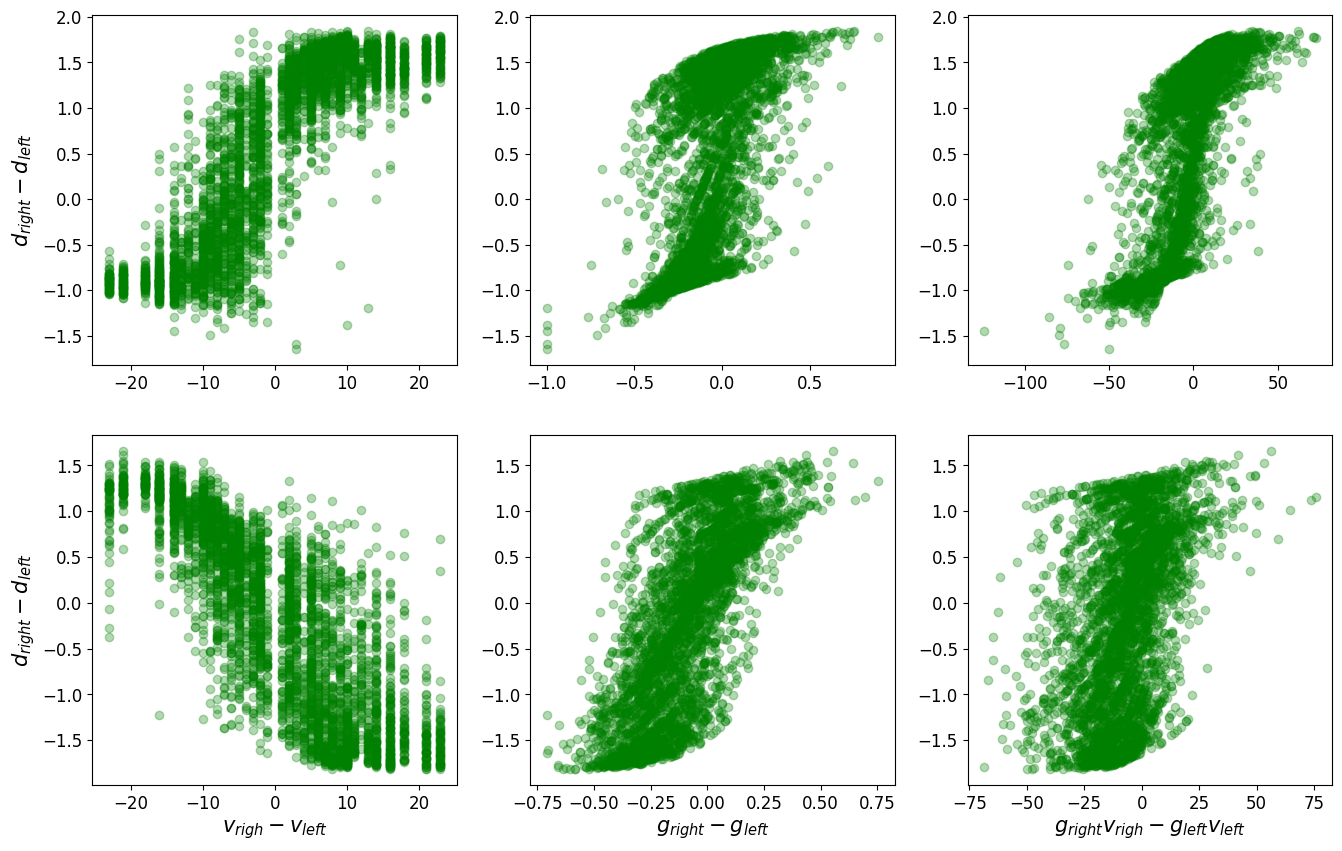

In [13]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
plt.scatter(X_test[X_test[:, -1]==1, 1] - X_test[X_test[:, -1]==1, 0], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(232)
plt.scatter(X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');


plt.subplot(233)
plt.scatter(X_test[X_test[:, -1]==1, 1]*X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 0]*X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');

#####################
plt.subplot(234)
plt.scatter(X_test[X_test[:, -1]==-1, 1] - X_test[X_test[:, -1]==-1, 0], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$v_{righ} - v_{left}$ ');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(235)
plt.scatter(X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(236)
plt.scatter(X_test[X_test[:, -1]==-1, 1]*X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 0]*X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/sp2020_perceptual_complete_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');